# Maximum Likelihood RUN 1

### The raw PyBDSF catalogue, optical, NIR catalogues and, the MASTER LIST are used

---

In [39]:
# Load in all the required functions

from socket import gethostname

if gethostname() == 'colonsay':
    PATH_START = '/disk1/rohitk/ELN1_project/'

elif gethostname() == 'rohitk-elitebook':
    PATH_START = '/home/rohitk/Documents/PhD/Year1/ELN1_project/'

import sys

# Import some important functions
#sys.path.append(PATH_START+'basic_functions')

import importlib

# Import coordinate converstion functions
from useful_functions import field_filter, get_overlap_sources, latest_dir, logspace_bins, return_hist_par
from plot_func import rc_def, make_fig
from moc_util import coords_to_hpidx, inMoc
rc_def()
##################################################

import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import time

from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky


# Multiprocessin method of doing the ML analysis
import multiprocessing as mp
from functools import partial

import pickle

ts = time.time()
# %pylab inline
import matplotlib as mpl
#mpl.rcParams["font.size"] = 18
#mpl.rcParams["xtick.labelsize"] = 18
#mpl.rcParams["ytick.labelsize"] = 18
#mpl.rcParams["axes.labelsize"] = 18

import os
from time import strftime
import glob

# For MOC files
import pymoc.io.fits
import healpy as hp
import pymoc.util.catalog

In [2]:
# Import ML functions from mlrun1
import mlrun1_bootes
importlib.reload(mlrun1_bootes)


from mlrun1_bootes import (varstat, survey_area, get_sigma_all_old, get_fr_old, get_bin_list, get_n_m, get_q_m, 
                    generate_rand_pos_servs, get_Q0, compute_Fr, get_nm_interp,
                    get_qm_interp, get_lr)

from mlrun1_bootes import (generate_rand_pos_bootes, get_n_m_kde, get_q_m_kde, estimate_q_m_kde, get_sigma_all, gen_binc_binl)

# from mlrun1 import survey_area

### Survey areas <a class="anchor" id="survey-area"></a>

In [76]:
# Survey area definitions - used for generated random catalogue and select the relevant PanSTARRS sources

# Rectangular region for n(m) calculation for the optical data - this is NOT used for the 4.5 micron data
p_ra_down = 159.
p_dec_down = 56.5
p_ra_up = 164.0
p_dec_up = 58.5

p_ra_down = 160.2
p_dec_down = 57.5
p_ra_up = 164.1
p_dec_up = 59.1

# UKIDSS survey area

# Get the area of the rectangle used for n(m)
pan_area = survey_area(p_ra_up, p_dec_up, p_ra_down, p_dec_down)
print(pan_area / 3600**2)

3.27883656259


## Load Catalogues <a class="anchor" id="load-catalogues"></a>

In [3]:
# Definition of the paths
PATH_PYBDSF_RAW = "../lofar/deep_fields/Lockman/data/image_full_ampphase_di_m.NS_shift.blanked.scaled.cat.fits"
PATH_MASTER_LIST = "../lofar/deep_fields/Lockman/data/Lockman_MASTER_opt_spitzer_merged_cedit.fits"

In [4]:
# Get the type of catalogue (srl) or (gaul)
if PATH_PYBDSF_RAW.split("/")[-1][-8:-5] == "cat":
    cat_type = "_srl"
    id_type = "Source_id"  # Column name to choose - NOT USED
elif PATH_PYBDSF_RAW.split("/")[-1][-9:-5] == "gaul":
    cat_type = "_gaul"
    id_type = "Gaus_id"
    
print(cat_type)

_srl


In [5]:
# Read in Master List - This contains all of the magnitudes for the 20 filters
master = Table.read(PATH_MASTER_LIST)

# Read in Final Catalogue - LOFAR DATA
deepfull = Table.read(PATH_PYBDSF_RAW)


In [62]:
help_cat = Table.read('../../../HELP/dmu_products/dmu32/dmu32_Lockman-SWIRE/data/Lockman-SWIRE_20180219.fits')

## Filter LOFAR Catalogue and MASTER catalogue <a class="anchor" id="filter-lofar"></a>

In [48]:
#Skipping this until i have the moc file

# Read in the MOC file
PATH_MOC = "/disk3/rohitk/Bootes/Bootes_optical/moc_files/Bootes_I-band_MOC.fits"

# Generate a MOC class instance first
cata_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(cata_moc, PATH_MOC)

moc_area = cata_moc.area_sq_deg
print("Area of MOC: {0} sq. deg.".format(moc_area))

Area of MOC: 9.643885598599503 sq. deg.


In [9]:
#creating temporary moc using cat tomoc function
coords = SkyCoord(master['ALPHA_J2000'],master['DELTA_J2000'])
cata_moc = pymoc.util.catalog.catalog_to_moc(coords,1/360*u.degree,14)

In [12]:
# Filter the LOFAR catalogue to the overlapping area and S sources and a Maj size cut

maj_cut = 10.  # Major axis size cut (in arcsec) for radio catalogue

# Radio sources in MOC
radio_inmoc = inMoc(deepfull["RA"], deepfull["DEC"], cata_moc)
print("Number of radio sources in MOC: {0}".format(np.sum(radio_inmoc)))

# Set this to False for the first run through. When using the output from the workflow (flowchart) which finds 
# the most suitable sources to be used for LR calibration, set this to True.
workflow_iter = False


if workflow_iter:
    workflow_latest_dir = latest_dir("/disk3/rohitk/Bootes/bootes_workflow/workflow_iter_*")
    indx_forlr = pickle.load(open(workflow_latest_dir + "/sources_to_send_to_lr.pckl", "rb"))
    
    print("***** USING LOFAR SOURCES FROM WORKFLOW OUTPUT ****")
    
else:
    indx_forlr = ((deepfull['S_Code'] == 'S') &
                  (deepfull["Maj"]*3600. <= maj_cut) &
                  (radio_inmoc))

# Now index and get the entire catalogue
final = deepfull[indx_forlr]
print("Number of radio sources in MOC, S and Maj < {0}'': {1}".format(maj_cut, np.sum(indx_forlr)))

# Radio sources in the rectangular area for n(m) calculation
radio_rect = field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, deepfull["RA"], deepfull["DEC"])
print("Radio sources within rectangle, used for Q0 calculation: {0}".format(np.sum(radio_rect)))

Number of radio sources in MOC: 41856
Number of radio sources in MOC, S and Maj < 10.0'': 28665
Radio sources within rectangle, used for Q0 calculation: 17270


## I-band ML matching <a class="anchor" id="pani_analysis"></a>

### n(m) PanSTARRS i-band <a class="anchor" id="comp-nm_i"></a>

$\textbf{Definition:}$ n(m) is the number of sources in the optical/NIR catalogue below a magnitude, m within an area of 1arcsec (i.e. divide by the area of the survey)

In [92]:
filt = "i"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_th = 3.
snr_band = master[sflux_col] / master[seflux_col]

# Any null values for sources
null_mag = -99

Optical sources used for n(m) calculation: 336873
Properties of n(m) in i-band: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.00488    0.007734   0.003513   367        6.27784048414e-08 0.007928   0         


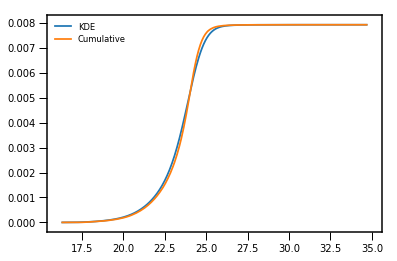

In [93]:
# Find all the optical catalogue sources within the rectangle and those with non-99 magnitudes and SNR >= threshold
master_rect_ind = ((field_filter(p_ra_up, p_dec_up, p_ra_down, p_dec_down, master["ALPHA_J2000"], master["DELTA_J2000"])) & (master[mag_col] != null_mag) &
                  ~np.isnan(master[mag_col]) & (snr_band >= snr_th))

print("Optical sources used for n(m) calculation: {0}".format(np.sum(master_rect_ind)))

# Get the bin_list for computing n(m) for i band
_, nm_be_i, nm_bc_i = return_hist_par(0.05, master[mag_col][master_rect_ind])

# Get n(m) for the i band
nm_i_old = get_n_m(master[mag_col][master_rect_ind], nm_be_i, pan_area)

nm_i = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in i-band: ")
varstat(np.cumsum(nm_i))

# Compute sigma for each source
# print("Diff in PanSTARRS area: " + str(46390728.8503 - pan_area)+" arcsec**2")

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(nm_i), label='KDE')
plt.plot(nm_bc_i, nm_i_old, label='Cumulative')
plt.legend()

In [16]:
# Write the n(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_i, nm_i, nm_i_old], open("LH_nm_{0}_{1}asec_apcorr.pckl".format(filt, ap), "wb"))

## q(m) PanSTARRS i-band <a class="anchor" id="comp-qm_i"></a>

$\textbf{Definition:}$ q(m) is the apriori probability that the radio source has a counterpart brighter than magnitude m.
* Depends on real(m) and Q$_0$

In [17]:
lofar_co = SkyCoord(final['RA'], final['DEC'], unit=(u.deg,u.deg),
                    frame='icrs')

# Define i-only sources as sources with a SNR > 3 in the i-band
i_only_bool = (master[mag_col] != null_mag) & (~np.isnan(master[mag_col]) & (snr_band >= snr_th))

i_coords = SkyCoord(master['ALPHA_J2000'][i_only_bool], 
                       master['DELTA_J2000'][i_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of LOFAR and I-band sources used in analysis from now on: ", len(lofar_co))
print("No. of i-band sources used for LR cross-match: {0}".format(np.sum(i_only_bool)))

No. of LOFAR and I-band sources used in analysis from now on:  28665
No. of i-band sources used for LR cross-match: 1851734


Unique opt_ind:  36872
Unique LOFAR ind:  22392


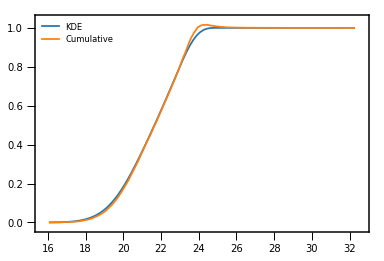

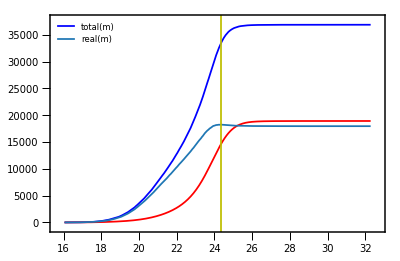

In [18]:
# Compute q(m)
RMAX = 5.

qm_i_old, tm_i, rm_i = get_q_m(lofar_co, i_coords, RMAX,
               master[mag_col][i_only_bool], nm_be_i, pan_area, nm_i_old)

nm_i = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_i, area=pan_area, bandwidth=0.5)
qm_i = estimate_q_m_kde(master[mag_col][i_only_bool], nm_bc_i, nm_i,
                        lofar_co, i_coords, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_i, np.cumsum(qm_i), label='KDE')
plt.plot(nm_bc_i, qm_i_old, label='Cumulative')
plt.legend()

fig = plt.figure()

plt.plot(nm_bc_i, tm_i, color='b', label='total(m)')
plt.plot(nm_bc_i, np.pi * RMAX**2 * np.cumsum(nm_i) * (len(lofar_co)), color='r')
plt.plot(nm_bc_i, rm_i, label='real(m)')
plt.axvline(x=nm_bc_i[np.argmax(rm_i)], ymin=0, ymax=1, color='y')

#plt.yscale('log')
plt.legend()


In [30]:
# Write the q(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_i, qm_i, qm_i_old], open("LH_qm_{0}_{1}asec_apcorr.pckl".format(filt, ap), "wb"))

### Compute Q$_0$ <a class="anchor" id="comp-q0_i"></a>

#### Firstly, redefine coordinates to include all the sources in the overlapping area

Timetaken: 4.586076974868774
Radius Blanks Random Blanks Q_0
1 8160 16842 0.5154969718560741
2 5869 15510 0.621598968407479
3 4812 13613 0.6465143612723132
4 4001 11379 0.6483873802618859
5 3317 9065 0.6340871483728627
6 2758 6985 0.6051539012168934
7 2298 5251 0.562369072557608
8 1908 3876 0.5077399380804953
9 1578 2856 0.4474789915966386


Text(0, 0.5, '$Q_0$')

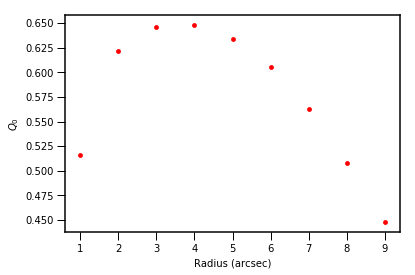

In [32]:
lofar_rect = SkyCoord(deepfull["RA"][radio_rect], deepfull["DEC"][radio_rect], unit='deg', frame='icrs')

# Compute Q_0 for the i band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_li = []
l_no_m_i = []
r_no_m_i = []

rad = np.arange(1,10)

# Generate random coords
rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_rect))

for k in range(len(rad)):
    q0_i, nl_non_i, nr_non_i = get_Q0(lofar_rect, i_coords, rand_coords, float(rad[k]))
    q0_li.append(q0_i)
    l_no_m_i.append(nl_non_i)
    r_no_m_i.append(nr_non_i)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_li)):
    
    print(rad[aa], l_no_m_i[aa], r_no_m_i[aa], q0_li[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_li, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [33]:
# Check the median Q0 value with the plot above to see if it is reasonable before saving the value
Q0 = np.median(q0_li[3:6])
print(Q0)

0.634087148373


In [34]:
# Write the Q0 value to file
pickle.dump(Q0, open("LH_Q0_{0}_{1}arcsec.pckl".format(filt,ap), "wb"))

In [35]:
# Estimate a mean Q_0 value for the i-band
mean_Q0_vals = []
mean_Q0_i = np.mean(q0_li[3:6])
# mean_Q0_i = np.max(q0_li)
print(mean_Q0_i)

mean_Q0_vals.append(mean_Q0_i)
# print("TAKING THE MAX of the Q0 vs radius distribution!")
print("Q_0 for i band: " + str(mean_Q0_i))

0.629209476617
Q_0 for i band: 0.629209476617


### Compute LR i-band <a class="anchor" id="run-lr_i"></a>

In [40]:
# Add the positional uncertainties column
opt_pos_err = 0.35 # / 3600.       # In degrees
# master["ERR_RA"] = opt_pos_err
# master["ERR_DEC"] = opt_pos_err

# Make the subset of MASTER catalogue which are in "i"
master_categ = master[i_only_bool]
print("Sources with i-band detection: " + str(len(master_categ)))

Sources with i-band detection: 1851734


In [41]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# This match returns x of possible counterparts within 15'' of a
# LOFAR source - compute LR for all x sources wrt the LOFAR source
# Take the max value of the LR


# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))
print("No. of radio sources without any positional cross-match: {0}".format(len(lofar_co) - len(ind_l_un)))

26597
No. of radio sources without any positional cross-match: 2068


In [42]:
# Functino to compute ML based on magnitude of possible conterpart and the sigma

def apply_ml(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    """
    Function which combines previous routines to compute ML values 
    for each ith LOFAR source that has a match within 15'' to opt/NIR catalogue
    
    Parameters:
    -----------
    i : Index of the LOFAR coordinates
    opt_cat_era : All of optical RA errors
    opt_cat_edec : All of optical Dec errors
    opt_cat_mag : All of the optical magnitudes
    fn_opt_indices : Field name of indices in MASTER catalogue
    mean_Q0 : Mean Q0 value for the band
    nm_categ : Cumulative n(m) distribution for the category
    qm_categ : Cumulative q(m) distribution for the category
    nm_bc_categ : Bin centres from the n(m) distribution
    
    Returns:
    --------
    res = [opt_index,dist,lr_value] : [Index into the optical catalogue,
                                        Separation to counterpart,
                                        LR value]
    """
    
    # Get the indices into the corresponding MASTER_category catalogue
    indx_o_match = indx_m[indx_l == i]
    s2d_o = s2d[indx_l == i]  # The 2d separation of the sources from LOFAR source
    
    # Indices corresponding to the FULL MASTER catalogue - the -1 to get into python index notation
    indx_o_master = master_categ["NUMBER"][indx_o_match]
    
    # Get the indices into the ACTUAL optical catalogue
    # indx_o = master_categ[fn_opt_indices][indx_o_match] -- Not used anymore with new catalogue
    
    # Now only select the optical catalogue sources which have an index value in master catalogue
    # indx_o_match = indx_o_match[indx_o != -99.]
    # s2d_o = s2d_o[indx_o != -99.]
    # indx_o = indx_o[indx_o != -99.]
    
    # Get the LOFAR positions and errors
    lofar_ra = final['RA'][i]
    lofar_dec = final['DEC'][i]
    lofar_pa = final['PA'][i]
    lofar_maj_err = final['E_Maj'][i]
    lofar_min_err = final['E_Min'][i]
    
    # Get the optical/NIR counterpart positions and positional errors
    c_ra = master_categ['ALPHA_J2000'][indx_o_match]
    c_dec = master_categ['DELTA_J2000'][indx_o_match]
    c_ra_err = opt_cat_era[indx_o_match]
    c_dec_err = opt_cat_edec[indx_o_match]
    
    # Magnitude of the counterparts
    c_mag = opt_cat_mag[indx_o_match]
    
    # Compute the sigma value for the ith LOFAR source and the possible
    # len(indx_o) optical counterparts
    
    """sig, sig_maj, sig_min = get_sigma_all_old(lofar_maj_err, lofar_min_err,
                                         lofar_pa, lofar_ra, lofar_dec,
                                         c_ra, c_dec, c_ra_err, c_dec_err)"""
    
    # New corrected angles Gaussian code - sig^2 is actually sigma_0_0 i.e. the average pos err squared?
    sigma_0_0, det_sigma = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    
    
    # Compute the LR of all the possible counterparts
    # Set the last argument to False if you do not want to apply the F(r) factor to q(m)
    c_lr = get_lr(c_mag, mean_Q0, nm_categ, qm_categ, np.sqrt(sigma_0_0), 
                  sigma_0_0, det_sigma, s2d_o.arcsec, nm_bc_categ, lof_opt_rad, True) 
    
    # Get indices of n=4 maximum values
    # lr_max_ind = c_lr.argsort()[-3:][::-1]
    
    # Get the index of the maximum 
    lr_max_ind = np.argmax(c_lr)
    
    
    result = [indx_o_master[lr_max_ind],     # i_band_index into the FULL master catalogue
              (s2d_o.arcsec)[lr_max_ind],    # Separation between counterpart and LOFAR source
              c_lr[lr_max_ind]]              # Max LR value
    
    return result



In [43]:

# A wrapper function to use multiple arguments
def merge_names_unpack(args):
    return apply_ml(*args)

# The number of cpu's to use
ncpu = mp.cpu_count()
ncpu_use = np.max([1, ncpu-1])

def run_parallel(i, opt_cat_era, opt_cat_edec, opt_cat_mag, fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ):
    
    pool = mp.Pool(processes=ncpu_use)
    #resu = pool.map(partial(apply_ml, opt_cat_era, opt_cat_edec, opt_cat_mag, 
    #                          fn_opt_indices, mean_Q0, nm_categ, qm_categ, nm_bc_categ), i)

    resu = pool.map(partial(apply_ml, opt_cat_era=opt_cat_era, opt_cat_edec=opt_cat_edec,
                                        opt_cat_mag=opt_cat_mag,fn_opt_indices=fn_opt_indices,
                                        mean_Q0=mean_Q0, nm_categ=nm_categ, qm_categ=qm_categ, nm_bc_categ=nm_bc_categ),i)

    return resu

t4 = time.time()
# ind_l_un = ind_l_un[:10]

res = run_parallel(ind_l_un, opt_pos_err*np.ones(len(master)), opt_pos_err*np.ones(len(master)),
                   master_categ[mag_col],'does_not_matter',
                   mean_Q0_i, nm_i, qm_i, nm_bc_i)

print(time.time() - t4)

lr_type = "i"

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

varstat(final["lr_"+lr_type])


86.83341884613037
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
40.581657  12.884373  62.862014  28665      0.0 382.968234 26        


### i-band LR Threshold


In [49]:
np.sum(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])]==0)

26

i-band threshold: 4.47725384799
No of nan LRs: 2068
No of LRs=0: 26
No of sources below threshold: 9862


Text(0.5, 0, '$log(LR)$')

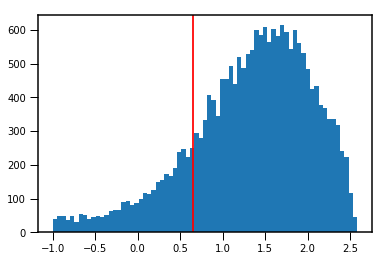

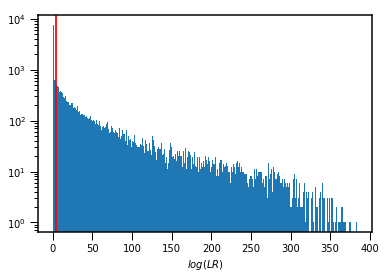

In [52]:
threshold_i = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_i))

print("i-band threshold: "+ str(threshold_i))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of LRs=0: " + str(len(final[(final["lr_"+lr_type]==0)])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_i)))

mask = (~np.isnan(final["lr_"+lr_type])) & (final["lr_"+lr_type]!=0)

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
plt.hist(np.log10(final["lr_"+lr_type][mask]), bins=lr_be)
plt.axvline(np.log10(threshold_i), 0, 100000, color='r')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][mask])
# print(lr_n)

fig = plt.figure()
plt.hist(final["lr_"+lr_type][mask], bins=lr_e)
plt.axvline((threshold_i), 0, 100000, color='r')

# plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$log(LR)$')

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
327.34336  322.101086 20.746764  173        300.141814437 382.968234 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
22.1731    22.465363  1.69425    26597      16.0807 30.9023    0         


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$log(LR)$')

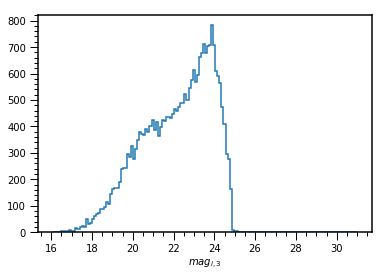

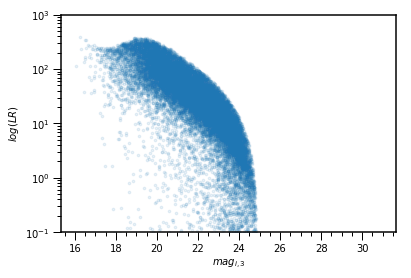

In [53]:
high_lr = final["lr_"+lr_type] > 300
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{i,3}$')

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 1000])
plt.xlabel('$mag_{i,3}$')
plt.ylabel('$log(LR)$')

## Spitzer Ch2 filter <a class="anchor" id="k-analysis"></a>

In [83]:
# Read in the MOC file
SERVS_MOC_PATH = "../lofar/deep_fields/Lockman/data/mocs/LH_swch2_moc_order_18_MOC.fits"

servs_moc = pymoc.MOC()
pymoc.io.fits.read_moc_fits(servs_moc, SERVS_MOC_PATH)

# Area in arcsec squared
servs_area = servs_moc.area_sq_deg * 3600**2

print("SERVS area from MOC: {0}".format(servs_moc.area_sq_deg))

SERVS area from MOC: 10.949807996199757


In [84]:
# Get the LOFAR and MASTER catalogue sources within the SERVS MOC
servs_ind = inMoc(master["ALPHA_J2000"], master["DELTA_J2000"], servs_moc)
lofar_sin = inMoc(deepfull["RA"], deepfull["DEC"], servs_moc)

In [85]:
# Define the mag column and the filter - Use SERVS 4.5
filt = "se2"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

# Get the sources with SNR > threshold in the filter
snr_band = (master[sflux_col] / master[seflux_col])

In [86]:
master_rect_ind = servs_ind & (master[mag_col] != null_mag) & (snr_band >= snr_th)
print(np.sum(master_rect_ind))
print("No. of SERVS sources in rectangular area: " + str(np.sum(master_rect_ind)))

503056
No. of SERVS sources in rectangular area: 503056


In [87]:
mask = ~np.isnan(help_cat['f_ap_irac_i1'])
mask = inMoc(help_cat['ra'][mask],help_cat['dec'][mask],servs_moc)
print('number of help sources with a SERVS flux is: {}'.format(np.sum(mask)))

KeyboardInterrupt: 

### n(m) Spitzer 4.5$\mu$m <a class="anchor" id="comp-nm_k"></a>

In [ ]:
# Get the bin_list for computing n(m) for g band
_, nm_be_ir, nm_bc_ir = return_hist_par(0.05, master[mag_col][master_rect_ind])

# Get n(m) for the g band
nm_ir_old = get_n_m(master[mag_col][master_rect_ind], nm_be_ir, servs_area)

nm_ir = get_n_m_kde(master[mag_col][master_rect_ind], nm_bc_ir, area=servs_area, bandwidth=0.5)

# Print properties of the n(m) distribution
print("Properties of n(m) in 4.5-band: ")
varstat(np.cumsum(nm_ir))

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(nm_ir), label='KDE')
plt.plot(nm_bc_ir, nm_ir_old, label='Cumulative')
plt.xlabel('$mag_{4.5}$')
plt.legend()


In [65]:
# Write the n(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_ir, nm_ir, nm_ir_old], open("LH_nm_{0}_{1}asec_apcorr.pckl".format(filt, ap), "wb"))

### q(m) Spitzer 4.5 $\mu$m <a class="anchor" id="comp-qm_k"></a>

In [72]:
# Get the IR sources within the SERVS region with good magnitudes and SNR > threshold

snr_th = 3.0
ir_only_bool_servs = (master[mag_col] != null_mag) & servs_ind & (snr_band >= snr_th)
print(np.sum(ir_only_bool_servs))

# Optical Coordinates
ir_coords_se = SkyCoord(master['ALPHA_J2000'][ir_only_bool_servs], 
                       master['DELTA_J2000'][ir_only_bool_servs],unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for q(m) calculation: {0}".format(np.sum(ir_only_bool_servs)))

lofar_co_se = SkyCoord(deepfull["RA"][lofar_sin], deepfull["DEC"][lofar_sin],unit='deg', frame='icrs')

print("No. of LOFAR sources used for q(m) calculation: {0}".format(lofar_co_se))

503050
No. of IR sources used for q(m) calculation: 503050
No. of LOFAR sources used for q(m) calculation: <SkyCoord (ICRS): (ra, dec) in deg
    [( 165.04968211,  57.36045019), ( 165.00901956,  57.34062476),
     ( 164.98167683,  57.37914716), ..., ( 159.34184712,  58.71101612),
     ( 159.33925964,  58.71435933), ( 159.32977296,  58.7157107 )]>


Unique opt_ind:  30666
Unique LOFAR ind:  17226
q(m) statistics: 
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
0.443559   0.254776   0.443854   245        0.0 1.0        18        
3027678
real m
2254420.16975


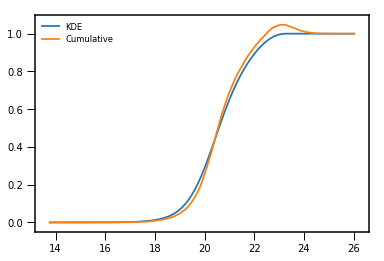

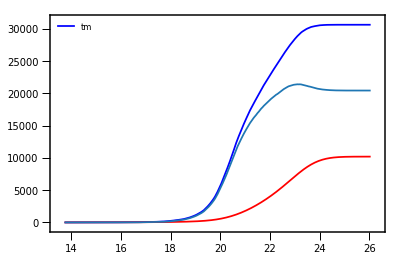

In [75]:
RMAX = 5.

# This is only estimated in the SERVS region
qm_ir_old, tm_ir, rm_ir = get_q_m(lofar_co_se, ir_coords_se, RMAX,
               master[mag_col][ir_only_bool_servs], nm_be_ir, servs_area, nm_ir_old)

qm_ir = estimate_q_m_kde(master[mag_col][ir_only_bool_servs], nm_bc_ir, nm_ir,
                        lofar_co_se, ir_coords_se, RMAX, bandwidth=0.5)

fig = plt.figure()

plt.plot(nm_bc_ir, np.cumsum(qm_ir), label='KDE')
plt.plot(nm_bc_ir, qm_ir_old, label='Cumulative')
plt.legend()


fig = plt.figure()

plt.plot(nm_bc_ir, tm_ir, color='b', label='tm')
plt.plot(nm_bc_ir, np.pi*RMAX**2 * np.cumsum(nm_ir) * len(lofar_co_se), color='r')
plt.plot(nm_bc_ir, rm_ir)
plt.legend()


print("q(m) statistics: ")
varstat(np.cumsum(qm_ir))

print(np.sum(tm_ir))
print("real m")
print(np.sum(rm_ir))

In [74]:
# Write the q(m) distribution to pckl file to compare with the other fields
pickle.dump([nm_bc_ir, qm_ir, qm_ir_old], open("LH_qm_{0}_{1}asec_apcorr.pckl".format(filt, ap), "wb"))

## Compute Q$_0$ <a class="anchor" id="comp-Q0_k"></a>

In [ ]:
# Compute Q_0 for the g band

t1 = time.time()

# Empty lists to store the output from the PanSTARRS catalogue
q0_lk = []
l_no_m_k = []
r_no_m_k = []

rad = np.arange(1,10)

# Generate random coords
# rand_coords = generate_rand_pos_bootes(p_ra_up,p_dec_up,p_ra_down,p_dec_down,len(lofar_co_se))

# Generate random coordinates using MOC - Make these coordinates be just larger than a rectangle encompassing the full SERVS region
ra_up = 0.
ra_down = 0.
dec_up = 0.
dec_down = 0.

rand_coords = gen_rand_cat_inMOC(len(lofar_co_se), ra_up, ra_down, dec_up, dec_down, servs_moc)

for k in range(len(rad)):
    q0_k, nl_non_k, nr_non_k = get_Q0(lofar_co_se, ir_coords_se, rand_coords, float(rad[k]))
    q0_lk.append(q0_k)
    l_no_m_k.append(nl_non_k)
    r_no_m_k.append(nr_non_k)

print('Timetaken: ' + str(time.time() - t1))

print('Radius Blanks Random Blanks Q_0')

for aa in range(len(q0_lk)):
    
    print(rad[aa], l_no_m_k[aa], r_no_m_k[aa], q0_lk[aa])


# Make a plot of Q0 vs radius
fig_q0 = plt.figure()

plt.plot(rad, q0_lk, 'r.')
#plt.yscale('log')
plt.xlabel('Radius (arcsec)')
plt.ylabel('$Q_0$')

In [ ]:
# Estimate a mean Q_0 value for the i-band

mean_Q0_ir = np.mean(q0_lk[3:6])
# mean_Q0_k = np.max(q0_lk)

print("Q_0 for 4.5-band: " + str(mean_Q0_ir))
mean_Q0_vals.append(mean_Q0_k)

In [ ]:
# Check the median Q0 value with the plot above to see if it is reasonable before saving the value
Q0 = np.median(q0_li[3:6])
print(Q0)

In [ ]:
# Write the Q0 value to file
pickle.dump(Q0, open("LH_dist/LH_Q0_{0}_{1}arcsec.pckl".format(filt,ap), "wb"))

# Redefine the LOFAR coordinates and master coordinates to the full SWIRE region

In [ ]:
# Redefine the IR magnitude to be taken from the full SWIRE 4.5um channel

filt = "sw2"
ap = "3"
flux_col = "FLUX_APER_" + filt + "_" + ap
eflux_col = "FLUXERR_APER_" + filt + "_" + ap
mag_col = "MAG_APER_" + filt + "_" + ap

# Aperture to use for SNR calculations
sflux_col = "FLUX_APER_" + filt + "_2"
seflux_col = "FLUXERR_APER_" + filt + "_2"

snr_band = master[sflux_col] / master[seflux_col]

In [ ]:
# Redefine the LOFAR and optical coordinates to be in the full SWIRE region

ir_only_bool = (master[mag_col] != null_mag) & (snr_band >= snr_th)

# Optical Coordinates
ir_coords = SkyCoord(master['ALPHA_J2000'][ir_only_bool], 
                       master['DELTA_J2000'][ir_only_bool],
                       unit=(u.deg,u.deg),frame='icrs')

print("No. of IR sources used for Q0 calculation and cross-match: {0}".format(np.sum(ir_only_bool)))
print("No. of LOFAR sources used for Q0 and cross-match: {0}".format(len(lofar_co)))

## Compute LR for 4.5-band

In [28]:
# Define the sub catalogue of master sources that are "K_only"
master_categ = master[ir_only_bool]
print("Sources with Spitzer ch2 detection: " + str(len(master_categ)))

Sources with Spitzer ch2 detection: 803759


In [29]:
# First match LOFAR to the MASTER catalogue -
# then calculate sigma for all matches in the optical catalogue 
# to a given LOFAR source

# Convert master positions to SkyCoord object
master_coords = SkyCoord(master_categ['ALPHA_J2000'], master_categ['DELTA_J2000'],
                         unit=(u.deg, u.deg), frame='icrs')

# New search radius to match the LOFAR and combined PanSTARRS WISE caalogue
lof_opt_rad = 15.

# Match the coordinates
indx_l, indx_m, s2d, _ = search_around_sky(lofar_co, master_coords, 
                                           lof_opt_rad*u.arcsec)

# Get the indices of LOFAR which have at least one match - only need to calculate LR for these sources
ind_l_un = np.unique(indx_l)
print(len(ind_l_un))
print("No. of radio sources without any positional cross-match: {0}".format(len(lofar_co) - len(ind_l_un)))

17895
No. of radio sources without any positional cross-match: 368


In [30]:
# Run the ML function

opt_pos_err = 0.35

t3 = time.time()


# Run the apply_ml function and store the values in res as a list
t4 = time.time()

res = run_parallel(ind_l_un, opt_pos_err*np.ones(len(master)), opt_pos_err*np.ones(len(master)),
                        master_categ[mag_col], 'does_not_matter', mean_Q0_ir, nm_ir, qm_ir, nm_bc_ir)

print(time.time() - t4)

lr_type = "ch2"
lr_types.append(lr_type)

# Create columns in the LOFAR catalogue to store the output of ML in iband
final["lr_"+lr_type] = np.nan
final["lr_dist_"+lr_type] = np.nan
final["lr_index_"+lr_type] = np.nan

# Map the outputs to a list - all non-matches have a nan value
(final["lr_index_"+lr_type][ind_l_un],
 final["lr_dist_"+lr_type][ind_l_un],
 final["lr_"+lr_type][ind_l_un]) = list(map(list, zip(*res)))

# Convert the index into ints as the map converts them to float
# final["lr_index_K"] = final["lr_index_K"].astype(int)

varstat(final["lr_"+lr_type])

8.699378967285156
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
157.343373 83.617974  195.407741 18263      0.0 1224.293776 4         


ch2-band threshold: 5.741713577977949
No of nan LRs: 368
No of sources below threshold: 1994


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0, '$log(LR)$')

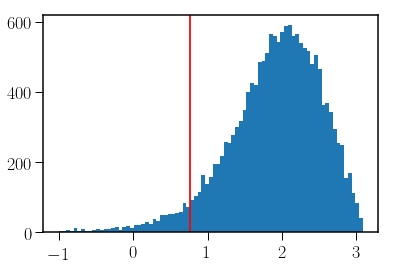

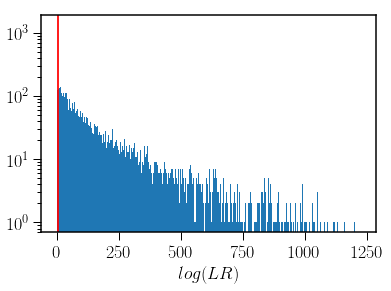

In [31]:
threshold_ch2 = np.nanpercentile(final["lr_"+lr_type], 100*(1 - mean_Q0_k))

print("ch2-band threshold: "+ str(threshold_ch2))

print("No of nan LRs: " + str(len(final[np.isnan(final["lr_"+lr_type])])))

print("No of sources below threshold: {0}".format(np.sum(final["lr_"+lr_type] < threshold_ch2)))

fig = plt.figure()
lr_be = logspace_bins(0.1, np.nanmax(final["lr_"+lr_type]), 0.05)
plt.hist(np.log10(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])]), bins=lr_be)
plt.axvline(np.log10(threshold_ch2), 0, 100000, color='r')

lr_n, lr_e, _ = return_hist_par(1, final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])])
# print(lr_n)

fig = plt.figure()
plt.hist(final["lr_"+lr_type][~np.isnan(final["lr_"+lr_type])], bins=lr_e)
plt.axvline((threshold_ch2), 0, 100000, color='r')

# plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('$log(LR)$')

Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
523.030582 462.640207 198.770703 2955       300.0244203357923 1224.293776 0         
Mean       Median     Std. Dev.  Length     Min        Max        Len_Zeros 
19.988079  19.913254  1.083214   17895      12.143552608004494 23.292252  0         


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/disk1/rohitk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, '$log(LR)$')

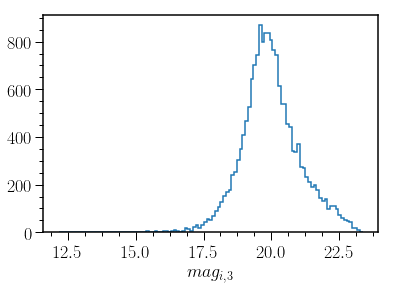

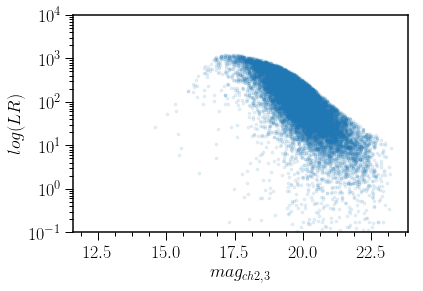

In [32]:
high_lr = final["lr_"+lr_type] > 300
varstat(final["lr_"+lr_type][high_lr])

good_lr_ind = (final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)
varstat(master[mag_col][(final["lr_index_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]).astype(int)])

_, me, mc = return_hist_par(0.1, master[mag_col][good_lr_ind])
fig, ax = make_fig()
plt.hist(master[mag_col][good_lr_ind], bins=me, histtype='step', lw=1.5)
plt.xlabel('$mag_{ch2,3}$')

fig, ax = make_fig()
plt.scatter(master[mag_col][good_lr_ind], (final["lr_"+lr_type][~np.isnan(final["lr_index_"+lr_type])]),
            s=7, alpha=0.1)
plt.yscale('log')
plt.ylim([0.1, 10000])
plt.xlabel('$mag_{ch2,3}$')
plt.ylabel('$log(LR)$')

# Run until here for now #

In [33]:
# Make a directory based on when the code is run to store output

if workflow_iter:
    add_str = "_workflow"
else:
    add_str = ""

# Make the general directory to store the catalogue
if os.path.exists(strftime("run1_matches"+add_str+"/%d_%m_%Y_1")):
    # Get list of directories created today
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y")
    dirs_today = sorted(glob.glob(outdir_name+"*"))

    # Now create a new output directory name by adding one to the last number
    last_num = int(dirs_today[-1][-1])
    
    # Now finally create the directory
    outdir_name = outdir_name+"_"+str(last_num+1)
    print(outdir_name)
    os.makedirs(outdir_name)
else:
    outdir_name = strftime("run1_matches"+add_str+"/%d_%m_%Y_1")
    os.makedirs(outdir_name)


In [34]:
outdir_name

'run1_matches_workflow/05_04_2019_1'

In [35]:
# Edit sources such that soucres below threshold are nans

# run_type = "1_faint"
run_type = "1"

field = "LH"

# Write the matches before setting threshold to be nan's
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type + cat_type, format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'.fits', format='fits', overwrite=True)

final["lr_index_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_index_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_dist_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_dist_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final["lr_i"][final["lr_i"] < threshold_i] = np.nan
final["lr_ch2"][final["lr_ch2"] < threshold_ch2] = np.nan

final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth', format='ascii', overwrite=True)
final.write(outdir_name + '/' + field + '_ML_RUN'+run_type+cat_type+'_nanth.fits', format='fits', overwrite=True)

print(time.time() - ts)
print("Mean Q0s: ")
print(mean_Q0_vals)

run1_filts = ["i", "ch2"]

# Write the mean Q0s to pckl file too
pickle.dump([run1_filts, mean_Q0_vals], open(outdir_name + "/run1_filts_and_mean_Q0.pckl", "wb"))

/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


369.06297540664673
Mean Q0s: 
[0.7561623016284411, 0.8886173866187995]


In [36]:
good_lr_i = final["lr_i"] >= threshold_i
good_lr_ir = final["lr_ch2"] >= threshold_ch2
print("LR > threshold i: {0}".format(np.sum(good_lr_i)))
print("LR > threshold IR: {0}".format(np.sum(good_lr_ir)))

print("LR > threshold in both optical and IR: {0}, {1}".format(np.sum(good_lr_i & good_lr_ir), np.sum(good_lr_i & good_lr_ir)/len(final)))
print("LR > threshold in optical OR IR: {0}, {1}".format(np.sum(good_lr_i | good_lr_ir), np.sum(good_lr_i | good_lr_ir)/len(final)))


LR > threshold i: 13341
LR > threshold IR: 15901
LR > threshold in both optical and IR: 13224, 0.7240869517603898
LR > threshold in optical OR IR: 16018, 0.8770738651919181


/disk1/rohitk/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [37]:
# Find the number of sources above the threshold in any of the bands
n_th = (~np.isnan(final["lr_i"]) | ~np.isnan(final["lr_ch2"]))
print("No. of sources above threshold in any band: " + str(len(final[n_th])))

print("Frac. of LOFAR sources above threshold : " + str(len(final[n_th])/float(len(final))))

No. of sources above threshold in any band: 16018
Frac. of LOFAR sources above threshold : 0.8770738651919181


In [38]:
# Move the HTML notebook to the output directory
os.system("jupyter-nbconvert MaxL_RUN1_LH.ipynb && mv MaxL_RUN1_LH.html {0}".format(outdir_name))

0